In [1]:
from datasets import Dataset, load_dataset, features, ClassLabel, load_from_disk

import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
from itertools import chain

import networkx as nx
import community as community_louvain
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms import bipartite

import seaborn as sns
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA

from llm_mri import LLM_MRI

/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carregando dados e configurando análise

Top quantil: 6.0
Botton quantil: 4.0
All columns ['annotation id', 'original', 'auto', 'organization level', 'global score', 'label']
top: 97
botton: 81
TOTAL: 447


,text,label
0,Acute myocardial infarction presents an epide...,top
1,Acute myocardial infarction (AMI) is a transmu...,top
2,"ANGINOSE EQUIVALENTS: VOMITING, SWEATING, ATY...",mid
3,AMI is a disease that affects the heart muscle...,mid
4,Acute myocardial infarction is one of the main...,mid


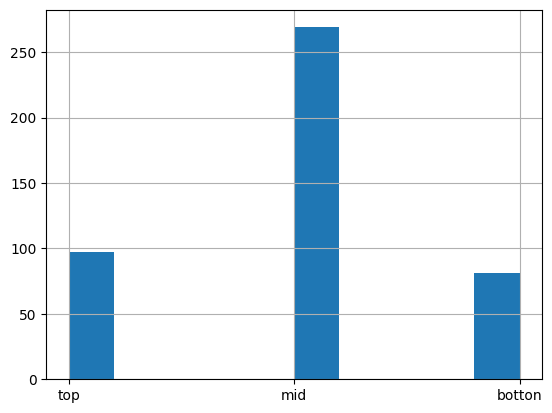

In [2]:
def label_answer(row, score, botton_quantile, top_quantile):
    if (row[score] < botton_quantile):
        return 'botton'
    elif (row[score] > top_quantile):
        return 'top'
    else:
        return 'mid'
        
exp = "_iam"
# exp = "_dpoc"
lang = "_pt"
# lang = "_en"
if "pt" in lang:
    text_column = 'original'
else:
    text_column = 'auto'
df_traducao = pd.read_csv('data/experimento_consolidado' + exp + '.csv')

score = 'global score'#organization_level,global_score
quantile = .3

print("Top quantil:", df_traducao[score].quantile(1 - quantile))
print("Botton quantil:", df_traducao[score].quantile(quantile))

#df_traducao[score].hist()

df_traducao['label'] = df_traducao.apply(
    label_answer,
    axis=1,
    score=score,
    botton_quantile=df_traducao[score].quantile(quantile),
    top_quantile=df_traducao[score].quantile(1 - quantile),
)

columns_to_remove = list(df_traducao.columns)
print("All columns", columns_to_remove)
columns_to_remove.remove(text_column)
columns_to_remove.remove('label')

df_data = df_traducao.rename(columns={text_column: 'text'}).drop(columns=columns_to_remove).reset_index(drop=True)


df_data['label'].hist()
# df_data = df_data.drop(df_data[df_data['label'] == "mid"].index).reset_index(drop=True)
print("top:", df_data['label'].loc[df_data['label'] == "top"].count())
print("botton:", df_data['label'].loc[df_data['label'] == "botton"].count())
print("TOTAL:", df_data['label'].count())
df_data.head()

# Passando os Dados para o Módulo

- converte o Dataframe para Dataset;
- carrega o modelo e os dados no módulo;
- processa as ativações;

In [3]:
subset = Dataset.from_pandas(df_data)
subset.cleanup_cache_files()

label_feature = subset.features['label']
class_names  = subset.unique("label")

class_feature = features.ClassLabel(names=sorted(class_names))
subset = subset.map(lambda str_value: {"label": class_feature.str2int(str_value)}, input_columns="label")

subset = subset.cast(features.Features({
    "label": class_feature,
    "text": subset.features["text"]}))

Casting the dataset: 100%|█████████| 447/447 [00:00<00:00, 281214.02 examples/s]


# Definindo Funções

In [4]:
def get_mapping(array):
    df_map = pd.DataFrame(array)
    #df_model['norm_label']=(df_model['label']-df_model['label'].min())/(df_model['label'].max()-df_model['label'].min())
    
    cell_numeration = {}
    
    for idx, data in enumerate(llm_mri.reduced_dataset):
        df_mid = data[['label','cell_label']].pivot_table(index=data.index, columns="cell_label")
        df_mid.columns = df_mid.columns.droplevel(0)
    
        cell_numeration[idx] = [df_map.columns.size, df_map.columns.size + df_mid.columns.size]
        
        df_map = pd.concat([
            df_map,
            df_mid
        ], axis=1)
    
    # Filtra as duas classes de interesse
    df_map = df_map[(df_map['label'] == 0) | (df_map['label'] == 2)]
    # df_model = df_model.replace(2.0, 'top')
    # df_model = df_model.replace(0, 'botton')
    # Reduz o valor da classe maior para um
    df_map = df_map.replace(2, 1)
    # Seta todos os valores ativados (classe top 1 ou classe botton 0) para 1 e todos os nulos para 0
    df_map.iloc[:,1:] = df_map.iloc[:,1:].notnull().astype('int')
    
    #pd.Series(df_model.iloc[:,2:].isnull().values.all(axis=0)).value_counts()
    return df_map

def get_embedding(og_df):
    # Compila as labes dos textos
    df_embedding = og_df['label']

    # Junta a esse df os valores de última camada do modelo transpostos em tabela
    df_embedding = pd.concat([df_embedding, pd.DataFrame(og_df.iloc[:,-1].to_list())], axis=1)

    # Filtra as duas classes de interesse
    df_embedding = df_embedding[(df_embedding['label'] == 0) | (df_embedding['label'] == 2)]
    # Reduz o valor da classe maior para um
    df_embedding['label'] = df_embedding['label'].replace(2.0, 1)
    
    return df_embedding

# Executando Experimento

In [5]:
# DEFINIÇÃO DE MODELOS E MAPEAMENTOS
models = { 
    "nlpie/tiny-clinicalbert": '?M',          
    # "distilbert-base-uncased": '67M',
    # "google-bert/bert-base-uncased": '110M',
    # "emilyalsentzer/Bio_ClinicalBERT": '110M',
    # "google-bert/bert-large-uncased": '330M',
    
    # "neuralmind/bert-base-portuguese-cased": "110M",
    # "pucpr/biobertpt-all": "110M",
    # "google-bert/bert-base-multilingual-cased": "110M",
    # "neuralmind/bert-large-portuguese-cased": "330M",
    # "pierreguillou/gpt2-small-portuguese": "1.5B",
    # "pucpr/gpt2-bio-pt": "1.5B",
    
    # "openai-community/gpt2": "1.5B",
    # "openai-community/gpt2-large": 36
    # "FacebookAI/xlm-roberta-large": '560M',
    # "facebook/xlm-roberta-xl": '3.48B'          # 3.48B
}
position = 1
map_dimensions = [
    5,
    # 10,
    # 25
]

test_prop = 0.25
random = 42
components = 20

# CRIAÇÃO DE ARQUIVOS
df_score = pd.DataFrame(columns = ['model','size','model_size','5x5_mean','5x5_std','10x10_mean','10x10_std','25x25_mean','25x25_std'])
# for model_name, model_size in models.items():
#     df_score = pd.concat([pd.DataFrame([model_name], columns=["model"]), df_score], ignore_index=True)
#     df_score.loc[df_score["model"] == model_name, 'size'] = model_size
#     df_score.loc[df_score["model"] == model_name, 'model_size'] = model_name + " " + model_size
#     df_score.to_csv('data/comparacao_f_pca_pt' + exp + '.csv', index=False)

# LEITURA E SOBRESCEVER ARQUIVOS
# df_score = pd.read_csv('data/comparacao_f_pca' + lang + exp + '.csv')

for model_name, model_size in models.items():
    # Cria a linha para o modelo
    df_score = pd.concat([pd.DataFrame([model_name], columns=["model"]), df_score], ignore_index=True)
    # Atribui valores de tamanho e nome com tamanho
    df_score.loc[df_score["model"] == model_name, 'size'] = model_size
    df_score.loc[df_score["model"] == model_name, 'model_size'] = model_name + " " + model_size
    
    for dimension in map_dimensions:
        # Processando áreas de ativação
        print("Loading:", model_name, " - ", dimension, " - ", model_size)
        llm_mri = LLM_MRI(model=model_name, device="cpu", dataset=subset)
        llm_mri.process_activation_areas(map_dimension = dimension)

        # Gerando Mapeamento
        df_map = get_mapping(llm_mri.reduced_dataset[0]['label'])
        # Criando o pca
        pca = PCA(n_components=components)

        # X_train, X_test, y_train, y_test = train_test_split(df_map.iloc[:,1:], df_map['label'], random_state=random)

        # Obtendo classificador
        logit_c_scores = cross_val_score(LogisticRegression(), pca.fit_transform(shuffle(df_map.iloc[:,1:], random_state = random)), shuffle(df_map['label'], random_state = random), cv=4, scoring='f1_macro')
    
        # Montando Embedding
        df_emb = get_embedding(llm_mri.hidden_states_dataset.to_pandas())
            
        # X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(df_emb.iloc[:,1:], df_emb['label'], random_state=random)
            
        logit_c_scores_emb = cross_val_score(LogisticRegression(), pca.fit_transform(shuffle(df_emb.iloc[:,1:], random_state = random)), shuffle(df_emb['label'], random_state = random), cv=4, scoring='f1_macro')

        # Registra os valores no df
        
        df_score.loc[df_score["model"] == model_name, str(dimension)+"x"+str(dimension)+"_mean"] = round(logit_c_scores.mean(), 2)
        df_score.loc[df_score["model"] == model_name, str(dimension)+"x"+str(dimension)+"_std"] = round(logit_c_scores.std(), 2)
        df_score.loc[df_score["model"] == model_name, "embedding_mean"] = round(logit_c_scores_emb.mean(), 2)
        df_score.loc[df_score["model"] == model_name, "embedding_std"] = round(logit_c_scores_emb.std(), 2)

        # Salva os dados no .csv
        # df_score.to_csv('data/comparacao_f_pca' + lang + exp + '.csv', index=False)
        

Loading: nlpie/tiny-clinicalbert  -  5  -  ?M


/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map:   0%|                                       | 0/447 [00:00<?, ? examples/s]Some weights of BertModel were not initialized from the model checkpoint at nlpie/tiny-clinicalbert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|█████████████████████████████| 447/447 [00:16<00:00, 27.40 examples/s]


In [11]:
df_map

,label,0_0_0,0_0_1,0_0_2,0_0_3,0_0_4,0_1_0,0_1_1,0_1_2,0_1_3,...,4_2_3,4_3_1,4_3_2,4_3_3,4_3_4,4_4_0,4_4_1,4_4_2,4_4_3,4_4_4
0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
436,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
438,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
440,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Mapping *Evaluation*

In [6]:
# average_function = "binary" # "weighted" "binary" "macro" 

# test_prop = 0.25
# random = 42
# X_train, X_test, y_train, y_test = train_test_split(df_model.iloc[:,1:], df_model['label'],
#                                                     test_size=test_prop, random_state=random)
# # Regressão Logística
# logit_c_scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=4, scoring='f1_macro')
# logit_clf = LogisticRegression().fit(X_train, y_train)
# logit_y_pred = pd.Series(logit_clf.predict(X_test))

# # Regressão Logística - OVERFITING
# logit_l1_c_scores = cross_val_score(LogisticRegression(penalty='l1', solver='saga'), X_train, y_train, cv=4, scoring='f1_macro')
# logit_l1_clf = LogisticRegression(penalty='l1', solver='saga').fit(X_train, y_train)
# logit_l1_y_pred = pd.Series(logit_l1_clf.predict(X_test))

# # Regressão Logística - OVERFITING
# logit_l2_c_scores = cross_val_score(LogisticRegression(penalty='l2', solver='saga'), X_train, y_train, cv=4, scoring='f1_macro')
# logit_l2_clf = LogisticRegression(penalty='l2', solver='saga').fit(X_train, y_train)
# logit_l2_y_pred = pd.Series(logit_l2_clf.predict(X_test))

# # Ridge Classificador
# ridge_c_scores = cross_val_score(RidgeClassifier(), X_train, y_train, cv=4, scoring='f1_macro')
# ridge_clf = RidgeClassifier().fit(X_train, y_train)
# ridge_y_pred = pd.Series(ridge_clf.predict(X_test))



# print(" --------- MAPPING f1-core --------- ")
# print("           Cross-validation")
# print("           mean      std")
# print("Logit f1:  %0.2f      %0.2f" % (logit_c_scores.mean(), logit_c_scores.std()))
# print("Log L1 f1: %0.2f      %0.2f" % (logit_l1_c_scores.mean(), logit_l1_c_scores.std()))
# print("Log L2 f1: %0.2f      %0.2f" % (logit_l2_c_scores.mean(), logit_l2_c_scores.std()))
# print("Ridge f1:  %0.2f      %0.2f" % (ridge_c_scores.mean(), ridge_c_scores.std()))
# # print("Tree f1:   %0.2f      %0.2f      %0.2f" % (metrics.f1_score(y_test, tree_y_pred, average=average_function), tree_c_scores.mean(), tree_c_scores.std()))
# # print("Forest f1: %0.2f      %0.2f      %0.2f" % (metrics.f1_score(y_test, forest_y_pred, average=average_function), forest_c_scores.mean(), forest_c_scores.std()))
# # print("SVM f1:    %0.2f      %0.2f      %0.2f" % (metrics.f1_score(y_test, svm_y_pred, average=average_function), svm_c_scores.mean(), svm_c_scores.std()))
# # print("MLP f1:    %0.2f      %0.2f      %0.2f" % (metrics.f1_score(y_test, mlp_y_pred, average=average_function), mlp_c_scores.mean(), mlp_c_scores.std()))

# *Embedding Evaluation*

In [7]:
# # df_embedding = pd.DataFrame(llm_mri.reduced_dataset[0]['label'])

# df_embedding = llm_mri.hidden_states_dataset.to_pandas()['label']

# df_embedding = pd.concat([df_embedding, pd.DataFrame(llm_mri.hidden_states_dataset.to_pandas()["hidden_state_6"].to_list())], axis=1)


# df_embedding = df_embedding[(df_embedding['label'] == 0) | (df_embedding['label'] == 2)]
# df_embedding['label'] = df_embedding['label'].replace(2.0, 1)
# # df_embedding['label'] = df_embedding['label'].replace(0, 0)
# # df_embedding = df_embedding.replace(2, 1)
# # df_embedding.iloc[:,1:] = df_embedding.iloc[:,1:].notnull().astype('int')

# df_embedding

In [8]:
# average_function = "binary" # "weighted" "binary" "macro" 

# test_prop = 0.25
# random = 42
# X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(df_embedding.iloc[:,1:], df_embedding['label'],
#                                                     test_size=test_prop, random_state=random)
# # Regressão Logística
# logit_c_scores = cross_val_score(LogisticRegression(), X_train_emb, y_train_emb, cv=4, scoring='f1_macro')
# logit_clf = LogisticRegression().fit(X_train_emb, y_train_emb)
# logit_y_pred = pd.Series(logit_clf.predict(X_test_emb))

# # Regressão Logística - OVERFITING
# logit_l1_c_scores = cross_val_score(LogisticRegression(penalty='l1', solver='saga'), X_train_emb, y_train_emb, cv=4, scoring='f1_macro')
# logit_l1_clf = LogisticRegression(penalty='l1', solver='saga').fit(X_train_emb, y_train_emb)
# logit_l1_y_pred = pd.Series(logit_l1_clf.predict(X_test_emb))

# # Regressão Logística - OVERFITING
# logit_l2_c_scores = cross_val_score(LogisticRegression(penalty='l2', solver='saga'), X_train_emb, y_train_emb, cv=4, scoring='f1_macro')
# logit_l2_clf = LogisticRegression(penalty='l2', solver='saga').fit(X_train_emb, y_train_emb)
# logit_l2_y_pred = pd.Series(logit_l2_clf.predict(X_test_emb))

# # Ridge Classificador
# ridge_c_scores = cross_val_score(RidgeClassifier(), X_train_emb, y_train_emb, cv=4, scoring='f1_macro')
# ridge_clf = RidgeClassifier().fit(X_train_emb, y_train_emb)
# ridge_y_pred = pd.Series(ridge_clf.predict(X_test_emb))

# # Árvore de decisão
# tree_clf = tree.DecisionTreeClassifier(
#     criterion="entropy",
#     # max_depth=5,
#     #min_samples_leaf=50,
#     #ax_leaf_nodes=30,
#     #class_weight="balanced"
# )
# tree_c_scores = cross_val_score(tree_clf, X_train_emb, y_train_emb, cv=4, scoring='f1_macro')
# tree_clf = tree_clf.fit(X_train_emb, y_train_emb)
# tree_y_pred = pd.Series(tree_clf.predict(X_test_emb))


# forest_clf = RandomForestClassifier(
#     # n_estimators = 100,
#     # criterion = 'entropy',
#     # max_depth = 5,
#     # class_weight= "balanced",
# )
# forest_c_scores = cross_val_score(forest_clf, X_train_emb, y_train_emb, cv=4, scoring='f1_macro')
# forest_clf = forest_clf.fit(X_train_emb, y_train_emb)
# forest_y_pred = pd.Series(forest_clf.predict(X_test_emb))


# svm_clf = svm.SVC()
# svm_c_scores = cross_val_score(svm_clf, X_train_emb, y_train_emb, cv=4, scoring='f1_macro')
# svm_clf = svm_clf.fit(X_train_emb, y_train_emb)
# svm_y_pred = pd.Series(svm_clf.predict(X_test_emb))


# mlp_clf = MLPClassifier(
#     # hidden_layer_sizes=(32,32,32),
#     # activation='relu', # 'identity' 'logistic' 'tanh' 'relu'
# #    solver='sgd',
# #    alpha=1e-4,
# #    learning_rate="invscaling",
# #    learning_rate_init = 1e-2,
# #    tol=1e-3
# )
# mlp_c_scores = cross_val_score(mlp_clf, X_train_emb, y_train_emb, cv=4, scoring='f1_macro')
# mlp_clf = mlp_clf.fit(X_train_emb, y_train_emb)
# mlp_y_pred = pd.Series(mlp_clf.predict(X_test_emb))


# print(" -------- EMBEDDING f1-core -------- ")
# print("           Cross-validation")
# print("           mean      std")
# print("Logit f1:  %0.2f      %0.2f" % (logit_c_scores.mean(), logit_c_scores.std()))
# print("Log L1 f1: %0.2f      %0.2f" % (logit_l1_c_scores.mean(), logit_l1_c_scores.std()))
# print("Log L2 f1: %0.2f      %0.2f" % (logit_l2_c_scores.mean(), logit_l2_c_scores.std()))
# print("Ridge f1:  %0.2f      %0.2f" % (ridge_c_scores.mean(), ridge_c_scores.std()))
# # print("Tree f1:   %0.2f      %0.2f      %0.2f" % (metrics.f1_score(y_test_emb, tree_y_pred, average=average_function), tree_c_scores.mean(), tree_c_scores.std()))
# # print("Forest f1: %0.2f      %0.2f      %0.2f" % (metrics.f1_score(y_test_emb, forest_y_pred, average=average_function), forest_c_scores.mean(), forest_c_scores.std()))
# # print("SVM f1:    %0.2f      %0.2f      %0.2f" % (metrics.f1_score(y_test_emb, svm_y_pred, average=average_function), svm_c_scores.mean(), svm_c_scores.std()))
# # print("MLP f1:    %0.2f      %0.2f      %0.2f" % (metrics.f1_score(y_test_emb, mlp_y_pred, average=average_function), mlp_c_scores.mean(), mlp_c_scores.std()))

## PCA

In [9]:
# test_prop = 0.25
# random = 42
# X_train, X_test, y_train, y_test = train_test_split(df_model.iloc[:,1:], df_model['label'],
#                                                     test_size=test_prop, random_state=random)

# pca = PCA(n_components=20)

# logit_c_scores = cross_val_score(LogisticRegression(), pca.fit_transform(X_train), y_train, cv=4, scoring='f1_macro')
# logit_clf = LogisticRegression().fit(pca.fit_transform(X_train), y_train)
# logit_y_pred = pd.Series(logit_clf.predict(pca.fit_transform(X_test)))

# tree_clf = tree.DecisionTreeClassifier(
#     criterion="entropy",
#     # max_depth=5,
#     #min_samples_leaf=50,
#     #ax_leaf_nodes=30,
#     #class_weight="balanced"
# )
# tree_c_scores = cross_val_score(tree_clf, pca.fit_transform(X_train), y_train, cv=4, scoring='f1_macro')
# tree_clf = tree_clf.fit(pca.fit_transform(X_train), y_train)
# tree_y_pred = pd.Series(tree_clf.predict(pca.fit_transform(X_test)))


# forest_clf = RandomForestClassifier(
#     # n_estimators = 100,
#     # criterion = 'entropy',
#     # max_depth = 5,
#     # class_weight= "balanced",
# )
# forest_clf = forest_clf.fit(pca.fit_transform(X_train), y_train)
# forest_y_pred = pd.Series(forest_clf.predict(pca.fit_transform(X_test)))
# forest_c_scores = cross_val_score(forest_clf, pca.fit_transform(X_train), y_train, cv=4, scoring='f1_macro')


# svm_clf = svm.SVC()
# svm_c_scores = cross_val_score(svm_clf, pca.fit_transform(X_train), y_train, cv=4, scoring='f1_macro')
# svm_clf = svm_clf.fit(pca.fit_transform(X_train), y_train)
# svm_y_pred = pd.Series(svm_clf.predict(pca.fit_transform(X_test)))


# mlp_clf = MLPClassifier(
#     # hidden_layer_sizes=(32,32,32),
#     # activation='relu', # 'identity' 'logistic' 'tanh' 'relu'
# #    solver='sgd',
# #    alpha=1e-4,
# #    learning_rate="invscaling",
# #    learning_rate_init = 1e-2,
# #    tol=1e-3
# )
# mlp_c_scores = cross_val_score(mlp_clf, pca.fit_transform(X_train), y_train, cv=4, scoring='f1_macro')
# mlp_clf = mlp_clf.fit(pca.fit_transform(X_train), y_train)
# mlp_y_pred = pd.Series(mlp_clf.predict(pca.fit_transform(X_test)))



# print(" --------- MAPPING f1-core --------- ")
# print("           Cross-validation")
# print("           mean      std")
# print("Logit f1:  %0.2f      %0.2f" % (logit_c_scores.mean(), logit_c_scores.std()))
# print("Tree f1:   %0.2f      %0.2f" % (tree_c_scores.mean(), tree_c_scores.std()))
# print("Forest f1: %0.2f      %0.2f" % (forest_c_scores.mean(), forest_c_scores.std()))
# print("SVM f1:    %0.2f      %0.2f" % (svm_c_scores.mean(), svm_c_scores.std()))
# print("MLP f1:    %0.2f      %0.2f" % (mlp_c_scores.mean(), mlp_c_scores.std()))



# X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(df_embedding.iloc[:,1:], df_embedding['label'],
#                                                     test_size=test_prop, random_state=random)
# # Regressão Logística
# logit_c_scores = cross_val_score(LogisticRegression(),  pca.fit_transform(X_train_emb), y_train_emb, cv=4, scoring='f1_macro')
# logit_clf = LogisticRegression().fit(pca.fit_transform(X_train_emb), y_train_emb)
# logit_y_pred = pd.Series(logit_clf.predict(pca.fit_transform(X_test_emb)))

# # Árvore de decisão
# tree_clf = tree.DecisionTreeClassifier(
#     criterion="entropy",
#     # max_depth=5,
#     #min_samples_leaf=50,
#     #ax_leaf_nodes=30,
#     #class_weight="balanced"
# )
# tree_c_scores = cross_val_score(tree_clf, pca.fit_transform(X_train_emb), y_train_emb, cv=4, scoring='f1_macro')
# tree_clf = tree_clf.fit(pca.fit_transform(X_train_emb), y_train_emb)
# tree_y_pred = pd.Series(tree_clf.predict(pca.fit_transform(X_test_emb)))


# forest_clf = RandomForestClassifier(
#     # n_estimators = 100,
#     # criterion = 'entropy',
#     # max_depth = 5,
#     # class_weight= "balanced",
# )
# forest_c_scores = cross_val_score(forest_clf, pca.fit_transform(X_train_emb), y_train_emb, cv=4, scoring='f1_macro')
# forest_clf = forest_clf.fit(pca.fit_transform(X_train_emb), y_train_emb)
# forest_y_pred = pd.Series(forest_clf.predict(pca.fit_transform(X_test_emb)))


# svm_clf = svm.SVC()
# svm_c_scores = cross_val_score(svm_clf, pca.fit_transform(X_train_emb), y_train_emb, cv=4, scoring='f1_macro')
# svm_clf = svm_clf.fit(pca.fit_transform(X_train_emb), y_train_emb)
# svm_y_pred = pd.Series(svm_clf.predict(pca.fit_transform(X_test_emb)))


# mlp_clf = MLPClassifier(
#     # hidden_layer_sizes=(32,32,32),
#     # activation='relu', # 'identity' 'logistic' 'tanh' 'relu'
# #    solver='sgd',
# #    alpha=1e-4,
# #    learning_rate="invscaling",
# #    learning_rate_init = 1e-2,
# #    tol=1e-3
# )
# mlp_c_scores = cross_val_score(mlp_clf, pca.fit_transform(X_train_emb), y_train_emb, cv=4, scoring='f1_macro')
# mlp_clf = mlp_clf.fit(pca.fit_transform(X_train_emb), y_train_emb)
# mlp_y_pred = pd.Series(mlp_clf.predict(pca.fit_transform(X_test_emb)))


# print(" -------- EMBEDDING f1-core -------- ")
# print("           Cross-validation")
# print("           mean      std")
# print("Logit f1:  %0.2f      %0.2f" % (logit_c_scores.mean(), logit_c_scores.std()))
# print("Tree f1:   %0.2f      %0.2f" % (tree_c_scores.mean(), tree_c_scores.std()))
# print("Forest f1: %0.2f      %0.2f" % (forest_c_scores.mean(), forest_c_scores.std()))
# print("SVM f1:    %0.2f      %0.2f" % (svm_c_scores.mean(), svm_c_scores.std()))
# print("MLP f1:    %0.2f      %0.2f" % (mlp_c_scores.mean(), mlp_c_scores.std()))

In [10]:
# print(" --------- MAPPING f1-core --------- ")
# print("           Cross-validation")
# print("           mean      std")
# print("Logit f1:  %0.2f      %0.2f" % (logit_c_scores.mean(), logit_c_scores.std()))
# print("Log L1 f1: %0.2f      %0.2f" % (logit_l1_c_scores.mean(), logit_l1_c_scores.std()))
# print("Log L2 f1: %0.2f      %0.2f" % (logit_l2_c_scores.mean(), logit_l2_c_scores.std()))
# print("Ridge f1:  %0.2f      %0.2f" % (ridge_c_scores.mean(), ridge_c_scores.std()))

# print(" -------- EMBEDDING f1-core -------- ")
# print("           Cross-validation")
# print("           mean      std")
# print("Logit f1:  %0.2f      %0.2f" % (logit_c_scores.mean(), logit_c_scores.std()))
# print("Log L1 f1: %0.2f      %0.2f" % (logit_l1_c_scores.mean(), logit_l1_c_scores.std()))
# print("Log L2 f1: %0.2f      %0.2f" % (logit_l2_c_scores.mean(), logit_l2_c_scores.std()))
# print("Ridge f1:  %0.2f      %0.2f" % (ridge_c_scores.mean(), ridge_c_scores.std()))